In [9]:
from pymoo.algorithms.moo.nsga2 import NSGA2, calc_crowding_distance, randomized_argsort
from pymoo.problems import get_problem
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.core.survival import Survival
import numpy as np
from pymoo.util.misc import find_duplicates, has_feasible
from sklearn.decomposition import PCA

class ZDT1(Problem):

    def __init__(self, n_var=30, **kwargs):
        super().__init__(n_var=n_var, n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=float, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * np.sum(x[:, 1:], axis=1)
        f2 = g * (1 - np.power((f1 / g), 0.5))

        g1 = f1 - 0.5
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])



In [10]:
def calc_biased_crowding_distance(F, filter_out_duplicates=True, index_important=1, index_scaling=10):
    n_points, n_obj = F.shape

    if n_points <= 2:
        return np.full(n_points, np.inf)

    else:

        if filter_out_duplicates:
            # filter out solutions which are duplicates - duplicates get a zero finally
            is_unique = np.where(np.logical_not(find_duplicates(F, epsilon=1e-32)))[0]
        else:
            # set every point to be unique without checking it
            is_unique = np.arange(n_points)

        # index the unique points of the array
        _F = F[is_unique]

        # _F[:, index_important] *= index_scaling  #ADDED LINE

        # sort each column and get index
        I = np.argsort(_F, axis=0, kind='mergesort')

        # sort the objective space values for the whole matrix
        _F = _F[I, np.arange(n_obj)]

        # calculate the distance from each point to the last and next
        dist = np.row_stack([_F, np.full(n_obj, np.inf)]) - np.row_stack([np.full(n_obj, -np.inf), _F])

        # calculate the norm for each objective - set to NaN if all values are equal
        norm = np.max(_F, axis=0) - np.min(_F, axis=0)
        norm[norm == 0] = np.nan

        weights = np.ones(n_obj)
        weights[index_important] = 1/index_scaling 

        # Normalize the weights so they add up to 1
        weights = weights / np.sum(weights)
        # prepare the distance to last and next vectors
        dist_to_last, dist_to_next = dist, np.copy(dist)
        dist_to_last, dist_to_next = weights * dist_to_last[:-1] / norm, weights * dist_to_next[1:] / norm
        # if we divide by zero because all values in one columns are equal replace by none
        dist_to_last[np.isnan(dist_to_last)] = 0.0
        dist_to_next[np.isnan(dist_to_next)] = 0.0

        # sum up the distance to next and last and norm by objectives - also reorder from sorted list
        J = np.argsort(I, axis=0)
        _cd = np.sum(dist_to_last[J, np.arange(n_obj)] + dist_to_next[J, np.arange(n_obj)], axis=1) / n_obj
        # save the final vector which sets the crowding distance for duplicates to zero to be eliminated
        crowding = np.zeros(n_points)
        crowding[is_unique] = _cd

    # crowding[np.isinf(crowding)] = 1e+14
    return crowding

class WeightedRankAndCrowdingSurvival(Survival):

    def __init__(self, nds=None, index=1, scaling=0.1) -> None:
        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.index = index
        self.scaling = scaling

    def _do(self, problem, pop, *args, n_survive=None, **kwargs):

        # get the objective space values and objects
        F = pop.get("F").astype(float, copy=False)

        # the final indices of surviving individuals
        survivors = []

        # do the non-dominated sorting until splitting front
        fronts = self.nds.do(F, n_stop_if_ranked=n_survive)
        for k, front in enumerate(fronts):

            # calculate the crowding distance of the front
            crowding_of_front = calc_biased_crowding_distance(F[front, :], index_important=self.index, index_scaling=self.scaling)

            # save rank and crowding in the individual class
            for j, i in enumerate(front):
                pop[i].set("rank", k)
                pop[i].set("crowding", crowding_of_front[j])

            # current front sorted by crowding distance if splitting
            if len(survivors) + len(front) > n_survive:
                # print("Front {} of length {} is split".format(k, len(front)))
                I = randomized_argsort(crowding_of_front, order='descending', method='numpy')
                I = I[:(n_survive - len(survivors))]
                # print("Splitted has length", len(I))

            # otherwise take the whole front unsorted
            else:
                # print("Front {} of length {} is taken entirely".format(k, len(front)))
                I = np.arange(len(front))

            # extend the survivors by all or selected individuals
            survivors.extend(front[I])

        return pop[survivors]

In [11]:
from pymoo.core.callback import Callback
class KeepGenerationsCallback(Callback):
    """A pymoo Callback for printing the generation
    """

    def __init__(self) -> None:
        super().__init__()
        self.generation_instances = []

    def notify(self, algorithm, **kwargs):
        instances = [x.X[0] for x in algorithm.pop]
        objectives = np.array([x.F for x in algorithm.pop])
        self.generation_instances.append(instances)
        this_gen = algorithm.n_gen
        print("Generation {} number of instances {}".format(this_gen, len(instances)))


In [12]:
def run_algo(problem, algorithm, algorithm_args, minimize_args):
    algo = algorithm(**algorithm_args)
    res = minimize(problem,
            algo,
            **minimize_args)
    return res

from pymoo.problems.multi.omnitest import OmniTest
problem = ZDT1(n_var=2)
# problem = get_problem("bnh")
# problem = get_problem("ctp1")
# problem = OmniTest(n_var=2)
cb = KeepGenerationsCallback()

from pymoo.termination.default import DefaultMultiObjectiveTermination

termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=100,
    n_max_evals=100000
)

# survival = WeightedRankAndCrowdingSurvival(index=0, scaling=10)
# survival = InputOutputCrowdingSurvival()
algorithm = NSGA2
algorithm_normal_arguments = {"pop_size":100,}

minimize_args = {"seed":1, "verbose":False, "termination":termination}
res_no_surv = run_algo(problem, algorithm, algorithm_normal_arguments, minimize_args)

results = [res_no_surv]

/home/panagiotou/anaconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/panagiotou/anaconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


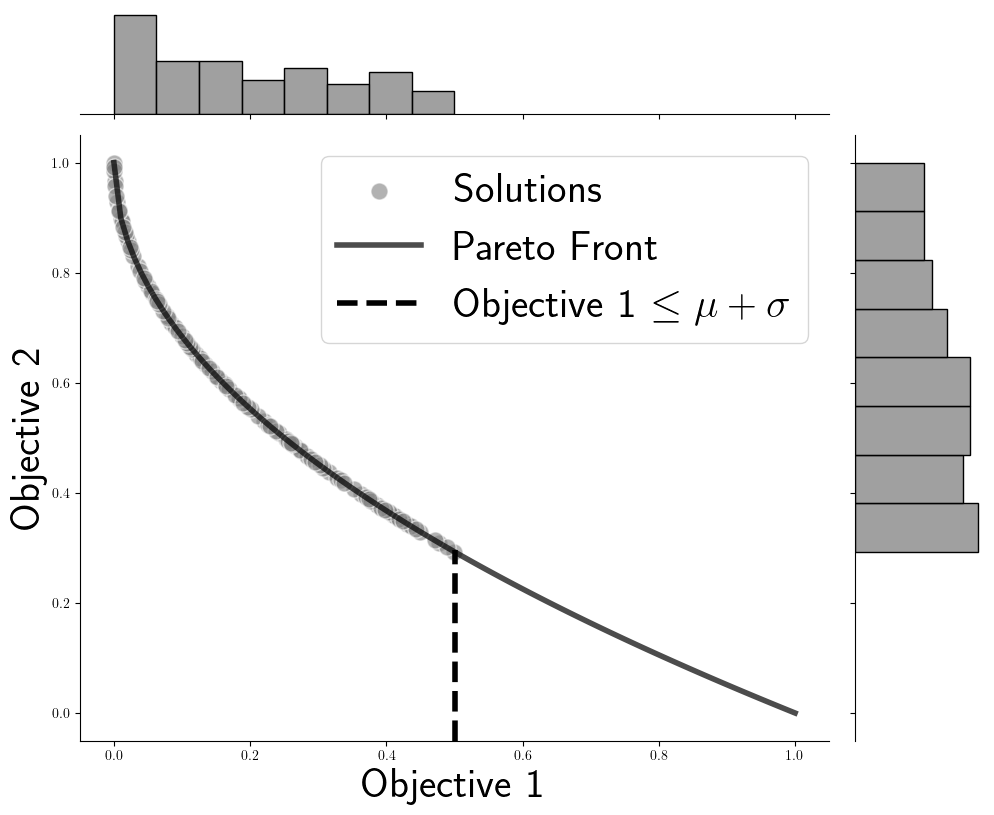

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

fontsize = 30
# Assuming problem.pareto_front() and res.F are numpy arrays
pareto_front = problem.pareto_front()
F = res_no_surv.F

# Create a jointplot
g = sns.jointplot(data=None, x=F[:, 0], y=F[:, 1], kind='scatter', color='grey', alpha=0.6, label='Solutions', s=150)

# Plot Pareto front
p = plt.plot(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', color='black', alpha=0.7, linewidth=4)

# Set threshold
threshold = 0.5

# Find intersection point on Pareto front
intersection_point = pareto_front[np.argmin(np.abs(pareto_front[:, 0] - threshold))]

# Draw vertical line
plt.axvline(x=threshold, ymin=0, ymax=(intersection_point[1] - g.ax_joint.get_ylim()[0]) / (g.ax_joint.get_ylim()[1] - g.ax_joint.get_ylim()[0]),
            color='black', linestyle='--', label='Objective 1 $\leq \mu + \sigma$', linewidth=4)


# Annotate the intersection point on x-axis
# plt.annotate(f'({threshold}, {intersection_point[1]:.2f})', 
#              xy=(threshold, 0), 
#              xytext=(threshold, -0.2), 
#              ha='center', 
#              arrowprops=dict(arrowstyle='->'))

# Add text indicating threshold value
# plt.text(threshold + 0.1, g.ax_joint.get_ylim()[0] - 0.2, f'Threshold = {threshold}', color='black', fontsize=10)

# Set labels
g.set_axis_labels('Objective 1', 'Objective 2', fontsize=fontsize)
g.fig.set_size_inches((10,8))
# Add legend
g.ax_joint.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=fontsize) 
# Show the plot
plt.savefig("ga_cut.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()


In [14]:
import json
with open("real_structures_evaluated.json") as f:
    real = json.load(f)


In [15]:
import pandas as pd
df_real = pd.DataFrame(real)

/home/panagiotou/anaconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


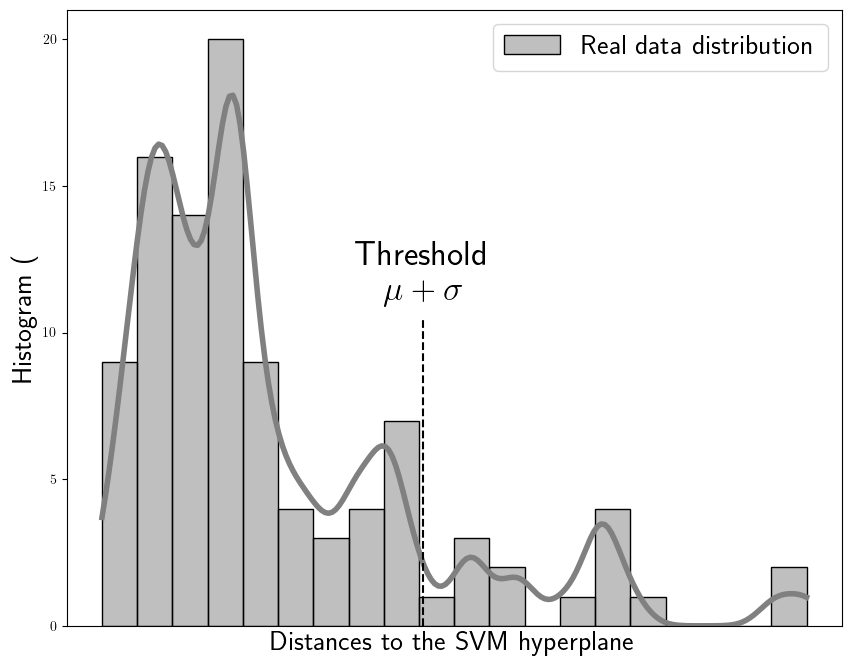

In [17]:
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize=(10,8))
fontsize = 20

m = np.mean(df_real["plausibility (One Class SVM) gamma=scale nu=0.5"])
s = np.std(df_real["plausibility (One Class SVM) gamma=scale nu=0.5"])
thr = m+s

sns.histplot(data=df_real, x="plausibility (One Class SVM) gamma=scale nu=0.5", kde=True, bins=20, color="grey", stat="percent", label="Real data distribution", line_kws={'linewidth': 4}, kde_kws={"bw_adjust":0.3})
plt.axvline(x=thr, ymin=0, ymax=0.5,
            color='black', linestyle='--')
plt.annotate('Threshold' + '\n' + '$\mu + \sigma$', xy=(thr, 10), xytext=(thr, 12), fontsize=fontsize+5, ha='center', va='center')

plt.xticks([], fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Histogram (%)', fontsize=fontsize)
plt.xlabel('Distances to the SVM hyperplane', fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
# plt.savefig("svm_distr.png", dpi=300, bbox_inches="tight", pad_inches=0)
